In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn
from importlib import reload
seaborn.set_style("whitegrid")

from EntryGuidance import Mesh 
from EntryGuidance import EntryEquations as EE
from EntryGuidance import Convex_Entry as CVX
from EntryGuidance import MonteCarloV as MC
from EntryGuidance import Parachute 

In [3]:
traj,bank_profile = MC.solve_ocp(dr=850)

Connected to existing (shared) Matlab instance.
Total OCP solution time 27.597278118133545 s


In [15]:
reload(Mesh)
reload(EE)
reload(CVX)
reload(MC)

<module 'EntryGuidance.MonteCarloV' from 'E:\\Documents\\EDL\\EntryGuidance\\MonteCarloV.py'>

In [16]:
mc = MC.MonteCarlo()
X,U_cvx,x_ref,u_ref,x_int = mc.reference_data(bank_profile, np.array(traj['state'])[-1,3])

r,th,ph,v,fpa,psi,bank = x_ref
h = r/1000-3397
Ef = mc.ref_sim.edlModel.energy(r,v,0)[-1]
print("Original final altitude: {:.2f} km".format(h[-1]))
print("Original final velocity: {:.2f}".format(v[-1]))

r,th,ph,v,fpa,psi,bank = X
h = r/1000-3397
Ef = mc.ref_sim.edlModel.energy(r,v,0)[-1]
print("Replanned final altitude: {:.2f} km".format(h[-1]))
print("Replanned final velocity: {:.2f}".format(v[-1]))
U = {}
U['CVX'] = U_cvx
U['Reference'] = u_ref

Generating reference data...
...done. 
(1447, 8)
Generating linearization about reference data...
...done.
Solving convex optimization problem...
status:        optimal_inaccurate
optimal value: 0.243
solution time:  1.685 s
setup time:     1.555 s
penalty value:  1.8692134768446257e-07

...done.

Original final altitude: 11.00 km
Original final velocity: 469.97
Replanned final altitude: 10.96 km
Replanned final velocity: 470.29


In [ ]:
plt.close('all')
fs = (16,8)
fontsize = 14
for xi,spec,label in zip([x_ref,X,x_int],['k--','r','b'],['Reference','CVX','Integrated']):
    if not "CVX" in label or True:
        r,th,ph,v,fpa,psi,bank = xi
        
        plt.figure(1, figsize=fs)
        plt.plot(v,r/1000-3397, spec,label=label)
        plt.xlabel('Velocity (m/s)', fontsize=fontsize)
        plt.ylabel('Altitude (km)', fontsize=fontsize)
        plt.legend(loc='best')

        plt.figure(10, figsize=fs)
        plt.plot(v[v<600],r[v<600]/1000-3397, spec, label=label)
        Parachute.Draw(10)
        plt.legend(loc='best')

        
        plt.figure(2, figsize=fs)
#         plt.plot(np.degrees(th),np.degrees(ph),spec,label=label)
#         plt.ylabel('Latitude (deg)', fontsize=fontsize)
#         plt.xlabel('Longitude (deg)', fontsize=fontsize)
        cr = (-3397*ph)
        plt.plot(th*3397,cr,spec,label=label)

#         plt.plot(th[cr>0.01]*3397,cr[cr>0.01],spec,label=label)
#         plt.plot(790, 0, 'ko', markersize=10, label='Target')

        plt.xlabel('Downrange (km)', fontsize=fontsize)
        plt.ylabel('Crossrange (km)', fontsize=fontsize)
        plt.legend(loc='best')
        
        plt.figure(3, figsize=fs)
        plt.plot(v,np.degrees(bank),spec,label=label)
        plt.xlabel('Velocity (m/s)', fontsize=fontsize)
        plt.ylabel('Bank (deg)', fontsize=fontsize)
        plt.legend(loc='best')



#         plt.figure(5, figsize=fs)
#         # plt.plot(v,np.degrees(th),spec)
#         plt.plot(v,-3397*ph,spec, label=label)
#         plt.ylabel('Crossrange (km)')
#         plt.xlabel('Velocity (m/s)', fontsize=fontsize)
        
        plt.figure(6, figsize=fs)
        plt.plot(v,np.degrees(psi),spec)
        plt.ylabel('Heading (deg)', fontsize=fontsize)
        plt.xlabel('Velocity (m/s)', fontsize=fontsize)
        
#         plt.figure(4, figsize=fs)
#         plt.plot(v,np.degrees(U[label]),spec)
#         plt.xlabel('Velocity (m/s)', fontsize=fontsize)
#         plt.ylabel('Bank rate (deg/s)', fontsize=fontsize)




plt.show()

Approximating Sequence of Riccati Equations
Current iteration: 1
Current cost: 22652.4270582
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 815.919872749
            Iterations: 424
            Function evaluations: 37001
            Gradient evaluations: 424
NLP time: 15.8370001316 s
Prop used: 2119.12704781 kg


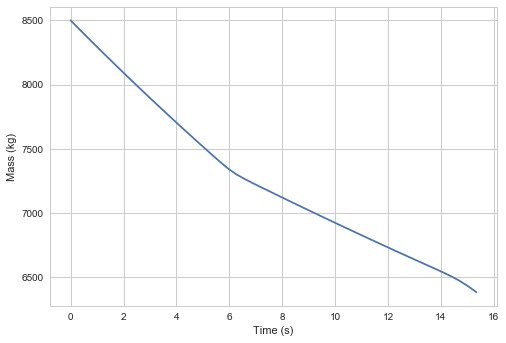

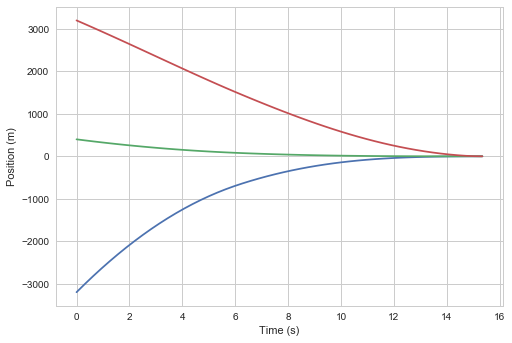

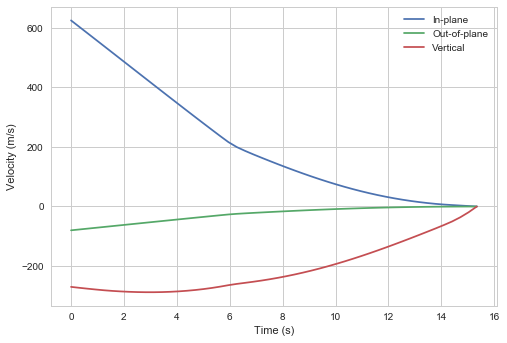

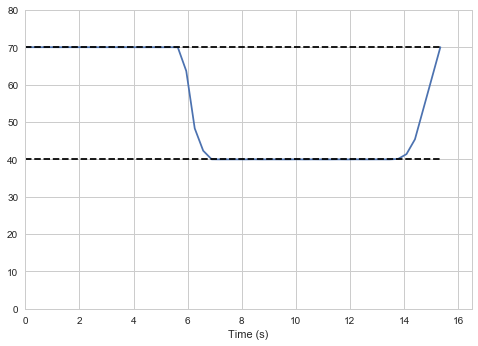

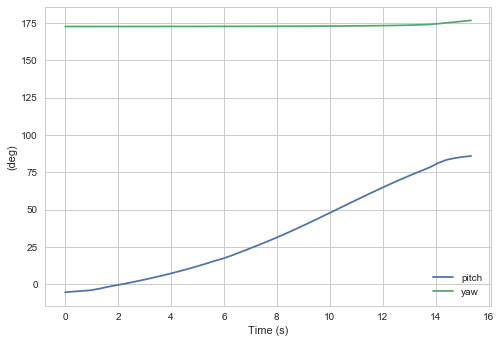

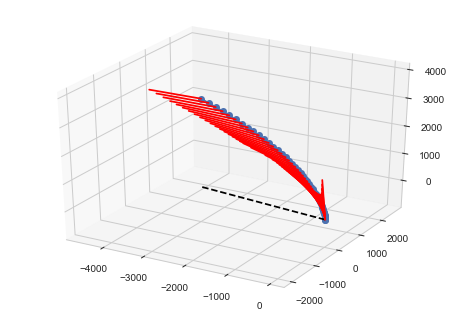

In [56]:
from EntryGuidance import bsplinePDG as PDG
reload(PDG)
PDG.optimize()

## Iterative Solution to SRP 

In [19]:
from EntryGuidance.Convex_PS import OCP 

import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint 
import matplotlib.pyplot as plt 
import seaborn
seaborn.set_style('whitegrid')

In [3]:
class SRP(OCP):
    def __init__(self, x0, xf, ubounds, xf_idx=None):
        # xf is a REDUCED list of final states, len(xf)=len(xf_idx)
        # xf_idx is a list of indices for fixed final states such that x[xf_idx] = xf
        self.vei = 1 # escape velocity inverse= 1/(Isp*g0), system is linear with no mass loss when = 0        
        
        self.x0 = np.array(x0)
        self.xf = np.array(xf)
        
        if xf_idx is not None:
            assert len(xf)==len(xf_idx)
            self.xfi = xf_idx
        else:
            self.xfi = list(range(self.x0.size))
            
        self.scale = np.linalg.norm(self.x0[3:6]) # Normalization factor for the full state vector 
        
    def dyn(self, x, t, u):
        p = x[0:3]
        v = x[3:6]
        m = x[6]
        g = np.array([0,0,3.71])
        dx = np.empty(x.shape)     
        dx[0:3] = v
        dx[3:6] = u/m - g
        dx[6] = -np.linalg.norm(u)*self.vei    
        return dx
        
    def jac(self, x, u):
        m = x[6]
        A = np.zeros((7,7))
        A[0:3][:, 3:6] = np.eye(3)
        A[3:6][:, 3:6] = np.eye(3)*(-u/m**2)

        B = np.zeros((7,3))
        B[3:6][:, 0:3] = np.eye(3)/m
        B[6] = -self.vei * u/np.linalg.norm(u)
        return A,B 

In [4]:
m0 = 8500
x0 = np.array([-3200., 400, 3200, 625., -80, -270., m0])
xf = np.zeros((6,))
xfi = np.arange(6)
ubnds = np.array([40,70])*m0 # Newtons 
srp = SRP(x0=x0, xf=xf, xf_idx=xfi, ubounds=ubnds)
# srp.solve()

In [7]:
u0 = np.array([70,70,70])
u = np.array([60,75,65])
x = np.array([-3100., 350, 3000, 615., -70, -260., m0*0.98])
f0 = srp.dyn(x0, 0, u0)/srp.scale
f = srp.dyn(x, 0, u)/srp.scale
print(f)
A,B = srp.jac(x0,u)
print(f0 + (A.dot(x-x0) + B.dot(u-u0))/srp.scale) 

[ 8.97141281e-01 -1.02113642e-01 -3.79279241e-01  1.05073204e-05
  1.31341505e-05 -5.40064008e-03 -1.69179161e-01]
[ 8.97141281e-01 -1.02113642e-01 -3.79279241e-01  1.03092883e-05
  1.28563245e-05 -5.40088086e-03 -1.69947909e-01]


In [21]:
# These are closed loop dynamics that depend on the initial costate 
def dynamics(x, t, l0):
    # Problem constants
    Isp = 290;
    g0 = 9.81;
    ve = Isp*g0;
    Tmax = 70*8500
    Tmin = 40*8500
    
    # States being integrated
    r = x[0:3]
    v = x[3:6]
    m = x[6]
    lm = x[7] # Mass costate 
    
    # Costates
    lr = l0[0:3]
    lv0 = l0[3:6]
    lv = lv0 - lr*t
    u = -lv/np.linalg.norm(lv) # Optimal thrust direction
    
    # Optimal thrust magnitude
    S = -lm/ve + np.dot(lv, u)/m
    if S < 0:
        T = Tmax
    else:
        T = Tmin
    
    # State derivatives
    g = np.array([0,0,3.71])
    dx = np.empty(x.shape)     
    dx[0:3] = v
    dx[3:6] = T*u/m - g
    dx[6] = -T/ve    
    dx[7] = T*np.dot(lv, u)/m**2
    return dx

In [27]:
l0 = np.array([0.204346904081385,	0.0663646852284269,	0.201041129500207,	3.17235427027352,	0.470730385571971,	0.565067899039915,	-0.748860889946803])
x0 = np.array([-3200., 400, 3200, 625., 0, -270., m0, l0[-1]])
tf = 14.0035

In [28]:
t = np.linspace(0,tf)
X = odeint(dynamics, x0, t, args=(l0,))
print("Prop used: {:.2f}".format(X[0,6]-X[-1,6]))

Prop used: 2109.38


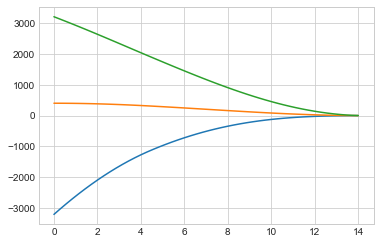

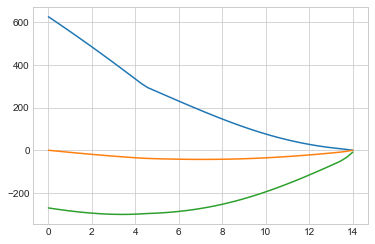

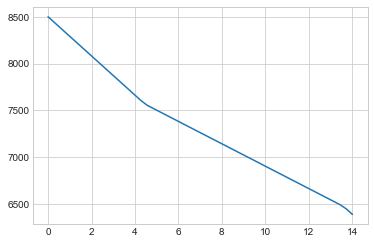

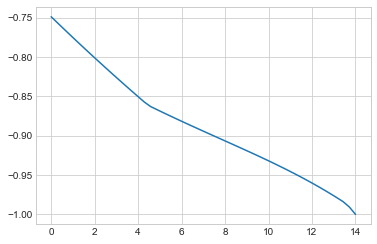

In [29]:
plt.figure()
plt.plot(t, X[:,0:3])
plt.figure()
plt.plot(t, X[:,3:6])
plt.figure()
plt.plot(t, X[:,6])
plt.figure()
plt.plot(t, X[:,7])

In [7]:
from EntryGuidance import Riccati
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint 
import matplotlib.pyplot as plt 


In [8]:
A = lambda x: np.array([x]).squeeze()
B = lambda x,u: np.array([1+x**2])
C = lambda x: np.array([1]) # Output equation linearization 
Q = lambda x: np.array([1-0.1*x**2]).squeeze() # State weight - less weight when far away 
R = lambda t: np.array([0.5/(1+t)]) # Control weight
z = lambda t: np.array([1+np.sin(t)+0.2*np.cos(2*t)/2]) #np.array([0]) # Reference trajectory
F = lambda x: Q(x)/10 #np.array([0]) # Final State weight 

tf = 12

x0 = np.array([1])
x, u, K = Riccati.ASRE(x0, tf, A, B, C, Q, R, F, z, tol=1e-3, max_iter=50, n_discretize=5000)
t = np.linspace(0, tf, x.size)

Uc = lambda T,X: interp1d(t, u, axis=0, bounds_error=False, fill_value=0)(T) - interp1d(t, K.squeeze(), axis=0, bounds_error=False, fill_value=0)(T)*(X - interp1d(t, x, axis=0, bounds_error=False, fill_value=0)(T))
Uo = lambda T,X: interp1d(t, u, axis=0, bounds_error=False, fill_value=0)(T) 

d = lambda x,t: 0.1*np.sin(t)*x
f = lambda x,t,u: x**2 + (1+x**2)*u(t,x) + d(x,t)

x_ol = odeint(f, x0, t, args=(Uo,)) # This should match with zero error essentially 
x_cl = odeint(f, np.linspace(0,2,10), t, args=(Uc,))
u_cl = [Uc(ti,xi) for ti,xi in zip(t,x_cl.squeeze())]
ref = z(t).squeeze()

Approximating Sequence of Riccati Equations
Max iterations: 50
Current iteration: 1
Current cost: 0.7895710251969738
Current iteration: 2
Current cost: 0.6088560399458006
Current iteration: 3
Current cost: 0.5991445034266731
Current iteration: 4
Current cost: 0.5963617844606172
Current iteration: 5
Current cost: 0.5960904171646377
Convergence achieved. 


E:\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


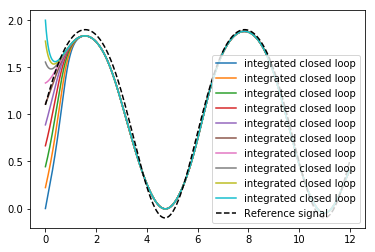

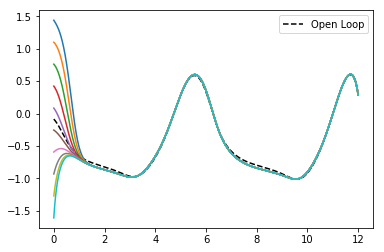

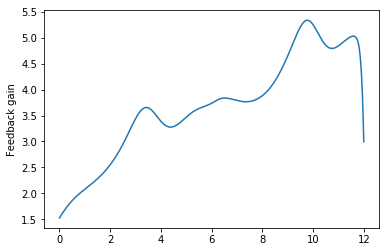

In [9]:
# plt.plot(t, x, 'mo',label='approx')
# plt.plot(t, x_ol, 'k-^', label='integrated open loop')
plt.plot(t, x_cl, label='integrated closed loop')
plt.plot(t, ref, 'k--', label='Reference signal')

plt.legend()

plt.figure()
plt.plot(t, u, 'k--', label='Open Loop')
plt.plot(t, u_cl)
plt.legend()

plt.figure()
plt.plot(t, K.squeeze())
plt.ylabel('Feedback gain')
plt.show()

## Closed loop covariance propagation
How does saturation effect the evolution?

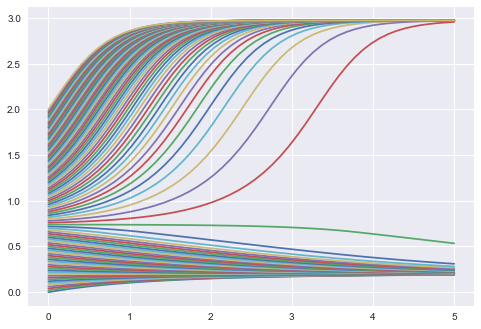

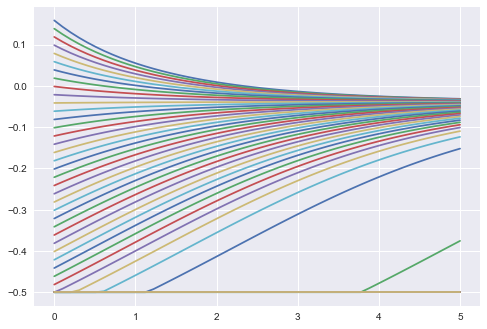

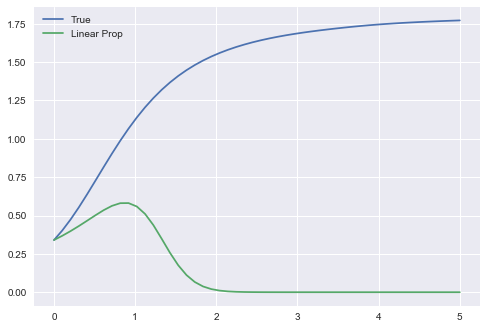

In [5]:
from EntryGuidance.Unscented import Transform 
tf = 5

x0 = np.linspace(0.,2,101)
t = np.linspace(0, tf, 50)

umax = 0.5
k = 1.
U = lambda t,x: np.clip(-np.sin(1)-k*(x-1), -umax, umax)
f = lambda x,t: np.sin(x)*x + U(t,x)
fp= lambda p,t,x: 2*p*(np.sin(x(t)) + x(t)*np.cos(x(t)) - k)

x = odeint(f, x0, t)
x_mean = odeint(f, np.mean(x0), t)
# x_mean = np.mean(x, axis=1)

u = [U(ti, xi) for ti,xi in zip(t,x.squeeze())]
P =  np.var(x, axis=1)
xt = interp1d(t,x_mean, axis=0, bounds_error=False, fill_value=(x_mean[0],x_mean[-1]))
Plin = odeint(fp, P[0], t, args=(xt,))

plt.figure()
plt.plot(t,x)

plt.figure()
plt.plot(t,u)

plt.figure()
plt.plot(t,P, label='True')
plt.plot(t,Plin, label='Linear Prop')
plt.legend()
plt.show()

In [1]:
import cvxpy as cvx

In [4]:
n = 3
x = cvx.Variable(n)
H = np.diag([1,-1,1.])
c = np.random.random((n,))

# print cvx.quad_form(x,H)
# print x[0]
constraint = [cvx.quad_form(x,np.abs(H)) < 1]
# constraint = [(x[0]**2 - x[1]**2 + x[2]**2)**2 < 1]

problem = cvx.Problem(cvx.Minimize(c*x), constraint)
problem.solve()
print x.value
print x.value.A.T.dot(np.abs(H)).dot(x.value.A)

[[-0.59096725]
 [-0.39423826]
 [-0.70379961]]
[[1.]]


In [7]:
print (cvx.quad_form(x,(H)) < 1).is_dcp()

False


e:\anaconda\lib\site-packages\cvxpy\atoms\quad_form.py:82: UserWarning: Forming a nonconvex expression quad_form(x, indefinite).
  warnings.warn("Forming a nonconvex expression quad_form(x, indefinite).")
